give a 2d dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
new = pd.read_csv("s1",encoding='latin',header=None)
A = []
for x in new[0]:
    x = x.strip().split('    ')
    A.append([(int)(x[0]),(int)(x[1])]) 
    
from sklearn.preprocessing import StandardScaler, MinMaxScaler

A=MinMaxScaler().fit_transform(A)
A = np.array(A)
A

array([[0.68391154, 0.54350367],
       [0.68570112, 0.55113605],
       [0.61280989, 0.57024472],
       ...,
       [0.66958421, 0.88094298],
       [0.61543589, 0.87815383],
       [0.70506817, 0.86060774]])

# 1. K-medoide

A variant of k-means, unique difference: In k-medoide, the center of each cluster need to be a point of the dataset (but k-means not)

In [3]:
from sklearn_extra.cluster import KMedoids

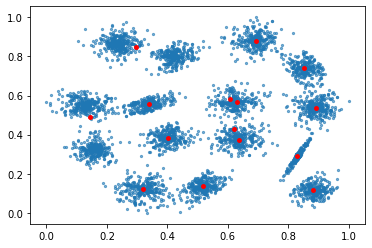

In [4]:
kmedoids = KMedoids(n_clusters=15, random_state=50).fit(A)
centers = kmedoids.cluster_centers_


fig=plt.figure()
ax = fig.add_subplot(111)
ax.scatter(A[:,0],A[:,1],alpha=0.6,s=5)
ax.scatter(centers[:,0],centers[:,1],c='r',s=15)

# 2. MMD-Critic

A prototype is a data instance that is representative of all the data. A criticism is a data instance that is not well represented by the set of prototypes

procedure:

1. Select the number of prototypes and criticisms you want to find.

2. Find prototypes with greedy search. Prototypes are selected so that the distribution of the prototypes is close to the data distribution.

3. Find criticisms with greedy search. Points are selected as criticisms where the distribution of prototypes differs from the distribution of the data.

### maximum mean discrepancy (MMD) ###

$MMD^2 = \frac{1}{m^2}\sum_{i,j\leq m} k(z_i,z_j) +\frac{1}{n^2}\sum_{i,j\leq n}k(x_i,x_j)-\frac{2}{mn}\sum_{i\leq m, j\leq n} k(z_i,x_j)$

$n$: number of instances,  $x_i$: instance

$m$: number of prototypes, $z_i$: prototype

$k$: a kernel // like gaussien kernel


Find prototypes with greedy search.

    Start with an empty list of prototypes.
    While the number of prototypes is below the chosen number m:
    For each point in the dataset, check how much MMD2 is reduced when the point is added to the list of prototypes. Add the data point that minimizes the MMD2 to the list.
    Return the list of prototypes.
    
 

Find criticisms with greedy search.

$witness(x) = \frac{1}{n}\sum_{i\leq n}k(x,x_i) -\frac{1}{m}\sum_{i\leq m}k(x,z_i)$

    Criticisms are points with high absolute value in the witness function. Like prototypes, criticisms are also found through greedy search. But instead of reducing the overall MMD2, we are looking for points that maximize a cost function that includes the witness function and a regularizer term. The additional term in the optimization function enforces diversity in the points, which is needed so that the points come from different clusters.



In [5]:
import math

In [6]:


def greedy_select_protos(K, candidate_indices, m):

    if len(candidate_indices) != np.shape(K)[0]:
        K = K[:,candidate_indices][candidate_indices,:]

    n = len(candidate_indices)
    colsum = 2*np.sum(K, axis=0) / n

    selected = np.array([], dtype=int)
    for i in range(m):
        argmax = -1
        candidates = np.setdiff1d(range(n), selected)

        s1array = colsum[candidates]

        if len(selected) > 0:
            temp = K[selected, :][:, candidates]
            s2array = np.sum(temp, axis=0)*2 + np.diagonal(K)[candidates]

            s2array = s2array/(len(selected) + 1)

            s1array = s1array - s2array

        else:
            s1array = s1array - (np.abs(np.diagonal(K)[candidates]))
        
        argmax = candidates[np.argmax(s1array)]

        selected = np.append(selected, argmax)
    return candidate_indices[selected]

In [7]:
from scipy.spatial.distance import pdist, squareform

In [8]:
import sys

def select_criticism_regularized(K, selectedprotos, m, reg='logdet', is_K_sparse=True):

    n = np.shape(K)[0]
    if reg in ['None','logdet','iterative']:
        pass
    else:
        print("wrong regularizer :" + reg)
        exit(1)
    options = dict()

    selected = np.array([], dtype=int)
    candidates2 = np.setdiff1d(range(n), selectedprotos)
    inverse_of_prev_selected = None  # should be a matrix

    if is_K_sparse:
        colsum = np.array(K.sum(0)).ravel()/n
    else:
        colsum = np.sum(K, axis=0)/n

    for i in range(m):
        maxx = -sys.float_info.max
        argmax = -1
        candidates = np.setdiff1d(candidates2, selected)

        s1array = colsum[candidates]

        temp = K[selectedprotos, :][:, candidates]
        if is_K_sparse:
            s2array = temp.sum(0)
        else:
            s2array = np.sum(temp, axis=0)

        s2array = s2array / (len(selectedprotos))

        s1array = np.abs(s1array - s2array)
        if reg == 'logdet':
            if inverse_of_prev_selected is not None: # first call has been made already
                temp = K[selected, :][:, candidates]
                if is_K_sparse:
                    temp2 = temp.transpose().dot(inverse_of_prev_selected)
                    regularizer = temp.transpose().multiply(temp2)
                    regcolsum = regularizer.sum(1).ravel()# np.sum(regularizer, axis=0)
                    regularizer = np.abs(K.diagonal()[candidates] - regcolsum)

                else:
                    # hadamard product
                    temp2 = np.array(np.dot(inverse_of_prev_selected, temp))
                    regularizer = temp2 * temp
                    regcolsum = np.sum(regularizer, axis=0)
                    regularizer = np.log(np.abs(np.diagonal(K)[candidates] - regcolsum))
                s1array = s1array + regularizer
            else:
                if is_K_sparse:
                    s1array = s1array - np.log(np.abs(K.diagonal()[candidates]))
                else:
                    s1array = s1array - np.log(np.abs(np.diagonal(K)[candidates]))
        argmax = candidates[np.argmax(s1array)]
        maxx = np.max(s1array)

        selected = np.append(selected, argmax)
        if reg == 'logdet':
            KK = K[selected,:][:,selected]
            if is_K_sparse:
                KK = KK.todense()

            inverse_of_prev_selected = np.linalg.inv(KK) # shortcut
        if reg == 'iterative':
            selectedprotos = np.append(selectedprotos, argmax)

    return selected


In [23]:
pairwise_dists= squareform(pdist(A, 'euclidean'))

In [24]:
K1 = np.exp(-pairwise_dists ** 2 *100)  
### need to choose the kernel function
### need to choose the value of /lambda

In [25]:
prototypes = \
greedy_select_protos(K=K1, candidate_indices=np.arange(len(A)),m=15)

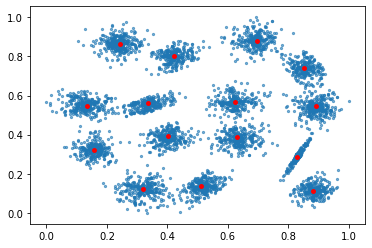

In [26]:
fig=plt.figure()
ax = fig.add_subplot(111)
ax.scatter(A[:,0],A[:,1],alpha=0.6,s=5)
ax.scatter(A[prototypes][:,0],A[prototypes][:,1],c='r',s=15)

In [34]:
critics=select_criticism_regularized(K=K1, selectedprotos = prototypes, 
                             m= 25, reg='logdet', is_K_sparse=False)

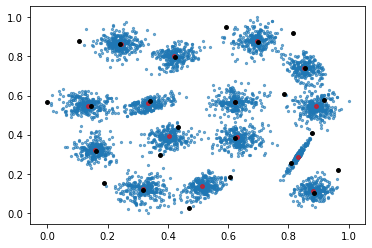

In [35]:
fig=plt.figure()
ax = fig.add_subplot(111)
ax.scatter(A[:,0],A[:,1],alpha=0.6,s=5)
ax.scatter(A[prototypes][:,0],A[prototypes][:,1],c='red',alpha=0.6,s=15)
ax.scatter(A[critics][:,0],A[critics][:,1],c='black',s=15)

In [36]:
critics

array([ 202,  772, 3076,  968, 1528, 2242, 3576, 2834,  599, 1906, 1711,
       4954, 3955, 3892, 3818, 4569,  322, 4225, 3316, 2719, 1435, 4719,
       2950, 4451, 4741])